In [1]:
from mol2vec import features
from mol2vec.helpers import depict_identifier
from rdkit import Chem
from openbabel import openbabel
import os
import pandas as pd
import gensim as gs
import numpy as np

Leer salidas de mol2vec y generar dataframe

In [2]:
for i in range(2, 9):
    if i == 2:
        df = pd.read_csv(f"out{i:02d}.csv")
    else:
        df = pd.concat([df, pd.read_csv(f"out{i:02d}.csv")])
print(df.head())
print(df.count())

   Unnamed: 0 Smiles  ID  mol2vec-000  mol2vec-001  mol2vec-002  mol2vec-003  \
0           0     CC   1    -0.591409    -0.250325     0.630409     0.835077   
1           1     CN   2     0.144022    -0.029161     0.302329     0.355394   
2           2     CO   3     0.095167    -0.244361     0.299303     0.151503   
3           3     CF   4    -0.532656    -0.316479    -0.232062     0.240368   
4           4     FF   5    -0.473902    -0.382634    -1.094533    -0.354341   

   mol2vec-004  mol2vec-005  mol2vec-006  ...  mol2vec-290  mol2vec-291  \
0     0.160757    -0.696366    -0.000482  ...    -0.963762    -0.743718   
1     0.040197    -0.722157    -0.135475  ...    -0.733461    -0.638595   
2     0.383190    -0.781686     0.265358  ...    -0.632573    -0.442339   
3     0.017260    -0.248504    -0.381119  ...    -0.688271    -0.802084   
4    -0.126237     0.199359    -0.761755  ...    -0.412781    -0.860451   

   mol2vec-292  mol2vec-293  mol2vec-294  mol2vec-295  mol2vec-296  

Covarianza

In [ ]:
matrix = df[df.columns[3:]].values

# Estandarizar
mean = np.mean(matrix, axis=0)
std = np.std(matrix, axis=0)
matrix = (matrix - mean) / std
cov_matrix = np.cov(matrix.T)
#print(cov_matrix)

# Calcular eigenvectores y eigenvalores
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
#print(eig_vals)

# Matriz diagonal
diag_matrix = np.diag(eig_vals)
#print(diag_matrix)


[[-0.48540464  1.48417614 -0.07246542 ...  1.71731839  0.84357552
   1.11619758]
 [ 0.08997414  1.66486901 -0.37556211 ...  1.96256877  1.21297617
   1.22068573]
 [ 0.05175118  1.48904851 -0.3783576  ...  2.2733643   1.10442127
   0.68555236]
 ...
 [ 0.5448716  -1.46595083 -1.1804481  ... -2.18324595 -0.44736237
  -0.89514943]
 [ 0.77788042 -1.97359067 -2.04652889 ... -1.62023764 -0.46443843
  -1.05395604]
 [ 0.8360615  -1.56541855 -1.32258781 ... -2.0858185  -1.20081786
   0.20950131]]


Crear molécula objetivo

In [2]:
molecula = Chem.MolFromSmiles('OC1=CNC=N1')
#molecula = Chem.MolFromSmiles('CC1CC(=O)N1')
sentence = features.mol2alt_sentence(molecula, 1)
model = gs.models.Word2Vec.load('model.plk')
vec = features.sentences2vec([sentence], model) #NOTA: mol2vec utiliza la suma de los vectores de las moleculas, no el promedio
vec_1d = vec.reshape(-1)
print(vec_1d.shape)


(300,)


[16:38:21] DEPRECATION WARNING: please use MorganGenerator


Calcular distancias

In [1]:
# Necesita cupy
import cupy as cp
def mahalanobis_CU(u, v, VI):
    u = cp.asarray(u)
    v = cp.asarray(v)
    VI = np.atleast_2d(VI)
    VI = cp.asarray(VI)
    delta = cp.subtract(u, v)
    m = cp.dot(cp.dot(delta, VI), delta)
    return cp.sqrt(m).get()

c:\Users\locua\anaconda3\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [65]:
from scipy.spatial.distance import mahalanobis
for index, row in df.iterrows():
    vec2 = row[3:]
    vec2 = np.array(vec2)
    vec2_1d = vec2.reshape(-1)

    #Distancia de mahalanobis
    dist = mahalanobis(vec_1d, vec2_1d, np.ling.inv(cov_matrix))
    df.at[index, 'mahalanobis'] = dist

    #Distancia euclidiana
    dist = np.linalg.norm(vec - vec2)
    df.at[index, 'euclidean'] = dist

    #Distancia de mahanobis diagonal
    dist = mahalanobis(vec_1d, vec2_1d, np.linalg.inv(diag_matrix))
    df.at[index, 'mahalanobis_diag'] = dist

Guardar data frame

In [74]:
file = open('out_df.csv', 'w')
file.write(df.to_csv(index=False))
file.close()

Leer dataframe

In [6]:
file = open('out_df.csv', 'r')
df = None
df = pd.read_csv(file)

In [7]:
print(df.sort_values(by='mahalanobis').head(10)[['Smiles', 'mahalanobis']])
print(df.sort_values(by='euclidean').head(10)[['Smiles', 'euclidean']])
print(df.sort_values(by='mahalanobis_diag').head(10)[['Smiles', 'mahalanobis_diag']])

                  Smiles  mahalanobis
50716     O=c1nc[nH]cc1O    21.519855
70257      OCc1c[nH]cc1O    24.467704
70256      CCc1c[nH]cc1O    24.748616
79323  c1nc(C2CC2)c[nH]1    24.976893
70367     C=Cc1c[nH]cc1O    25.251691
57530      FCCc1c[nH]cn1    25.272162
57527      CCCc1c[nH]cn1    25.298696
50993     O=c1cc[nH]cc1O    25.333395
70258      Oc1c[nH]cc1CF    25.387583
70838      NCc1c[nH]cc1O    25.387730
                  Smiles  euclidean
50716     O=c1nc[nH]cc1O  12.461014
44693   O=c1ncc(O)c[nH]1  13.342111
50993     O=c1cc[nH]cc1O  13.479823
51331     N=c1cc[nH]nc1O  13.642552
27274   O=c1cc(O)[nH]cn1  13.706850
26868   O=c1nc(O)cc[nH]1  14.000183
44689   N=c1ncc(O)c[nH]1  14.043087
79340  c1nc(C2CN2)c[nH]1  14.079159
51443     O=c1nn[nH]cc1O  14.081951
70256      CCc1c[nH]cc1O  14.088878
                 Smiles  mahalanobis_diag
50716    O=c1nc[nH]cc1O         70.240292
70285     OCc1c[nH]nc1O         73.185866
65170    ON=c1nc[nH]cn1         74.728760
70257     OCc1c[nH

Mostrar resultados

[16:45:09] DEPRECATION WARNING: please use MorganGenerator
[16:45:09] The new font size 0.8 is below the current minimum (6).


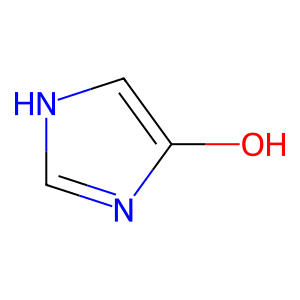

[16:45:10] DEPRECATION WARNING: please use MorganGenerator
[16:45:10] The new font size 0.8 is below the current minimum (6).


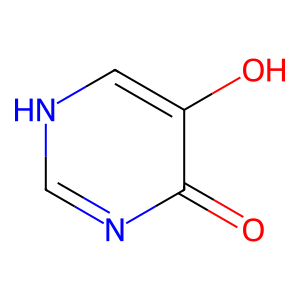

[16:45:10] DEPRECATION WARNING: please use MorganGenerator
[16:45:10] The new font size 0.8 is below the current minimum (6).


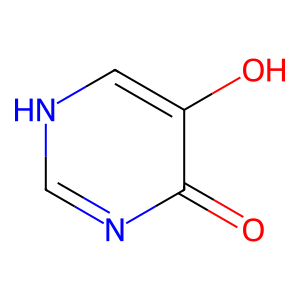

[16:45:10] DEPRECATION WARNING: please use MorganGenerator
[16:45:10] The new font size 0.8 is below the current minimum (6).


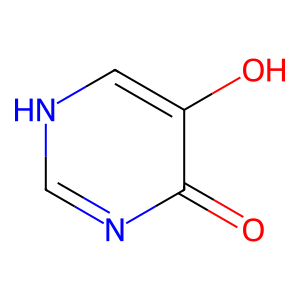

"for i in range(10):\n    maha = depict_identifier(Chem.MolFromSmiles(df.sort_values(by='mahalanobis').head(10)['Smiles'].values[i]), 847950754, 1)\n    maha = cairosvg.svg2png(bytestring=maha.data, write_to=dir + f'\\maha_{i}.png')\n    eucl = depict_identifier(Chem.MolFromSmiles(df.sort_values(by='euclidean').head(10)['Smiles'].values[i]), 847950754, 1)\n    eucl = cairosvg.svg2png(bytestring=eucl.data, write_to=dir + f'\\eucl_{i}.png')\n    maha_diag = depict_identifier(Chem.MolFromSmiles(df.sort_values(by='mahalanobis_diag').head(10)['Smiles'].values[i]), 847950754, 1)\n    maha_diag = cairosvg.svg2png(bytestring=maha_diag.data, write_to=dir + f'\\maha_diag_{i}.png')\n\nimages = []\nfor i in range(10):\n    images.append(imageio.imread(dir + f'\\maha_{i}.png'))\nimageio.mimsave(dir + '\\maha.gif', images, duration=2)\n\nimages = []\nfor i in range(10):\n    images.append(imageio.imread(dir + f'\\eucl_{i}.png'))\nimageio.mimsave(dir + '\\eucl.gif', images, duration=2)\n\nimages = []

In [8]:
id = depict_identifier(molecula, 847950754, 1)
from IPython.display import SVG, display
import imageio
import cairosvg

display(id)
#id = cairosvg.svg2png(bytestring=id.data, write_to=dir + '\id.png')

#Mostrar moleculas
id = depict_identifier(Chem.MolFromSmiles(df.sort_values(by='mahalanobis').head(10)['Smiles'].values[0]), 847950754, 1)
display(id)
id = depict_identifier(Chem.MolFromSmiles(df.sort_values(by='euclidean').head(10)['Smiles'].values[0]), 847950754, 1)
display(id)
id = depict_identifier(Chem.MolFromSmiles(df.sort_values(by='mahalanobis_diag').head(10)['Smiles'].values[0]), 847950754, 1)
display(id)

#Generar gif con las 10 moleculas mas cercanas
"""
dir = '..\salidas\png'
if not os.path.exists(dir):
    os.makedirs(dir)

for i in range(10):
    maha = depict_identifier(Chem.MolFromSmiles(df.sort_values(by='mahalanobis').head(10)['Smiles'].values[i]), 847950754, 1)
    maha = cairosvg.svg2png(bytestring=maha.data, write_to=dir + f'\maha_{i}.png')
    eucl = depict_identifier(Chem.MolFromSmiles(df.sort_values(by='euclidean').head(10)['Smiles'].values[i]), 847950754, 1)
    eucl = cairosvg.svg2png(bytestring=eucl.data, write_to=dir + f'\eucl_{i}.png')
    maha_diag = depict_identifier(Chem.MolFromSmiles(df.sort_values(by='mahalanobis_diag').head(10)['Smiles'].values[i]), 847950754, 1)
    maha_diag = cairosvg.svg2png(bytestring=maha_diag.data, write_to=dir + f'\maha_diag_{i}.png')

images = []
for i in range(10):
    images.append(imageio.imread(dir + f'\maha_{i}.png'))
imageio.mimsave(dir + '\maha.gif', images, duration=2)

images = []
for i in range(10):
    images.append(imageio.imread(dir + f'\eucl_{i}.png'))
imageio.mimsave(dir + '\eucl.gif', images, duration=2)

images = []
for i in range(10):
    images.append(imageio.imread(dir + f'\maha_diag_{i}.png'))
imageio.mimsave(dir + '\maha_diag.gif', images, duration=2)"""